## Explore response times of different intervention types

In [134]:
import numpy as np
import pandas as pd
import os

from lib.plotting import *
from lib.preferences import *

In [135]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style("ticks")
sns.set_style('white')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

## Load data

In [136]:
ls ../analysis/

2020-04-30_art-intv/ 2020-04-30_bed-intv/ 2020-04-30_ins-intv/


In [137]:
fn = "../analysis/2020-04-30_%s-intv/early/crash_dynamics.csv"
br_df = pd.read_csv(fn % "bed")
gamma_df = pd.read_csv(fn % "art")
nv_df = pd.read_csv(fn % "ins")

## Plotting preferences

In [138]:
plot_metrics = ops_metrics + tight_metrics
ms = (np.arange(len(plot_metrics))[1:] + np.arange(len(plot_metrics))[:-1])/2

In [139]:
genetic_names.update(op_names)
genetic_grps.update(op_grps)

In [140]:
cut_axis_days = 365

## Individual plot

In [141]:
df = br_df.query("metric in @plot_metrics")

Text(0.5, 0, 'Time (Years)')

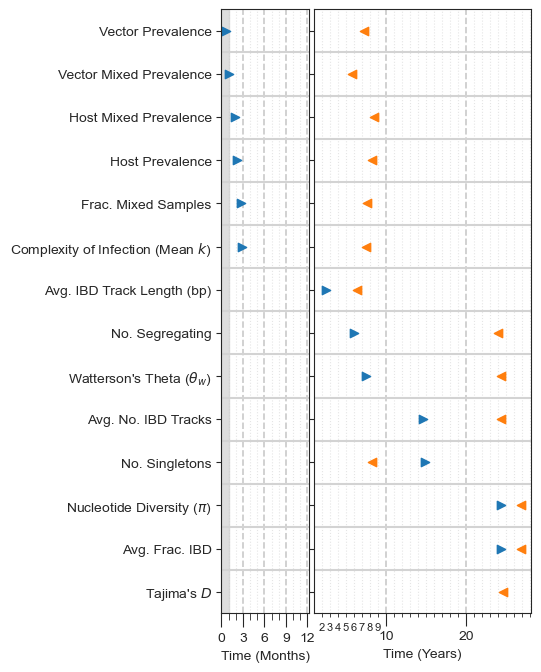

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(4, 8))

# Prepare slicing of axes
divider = make_axes_locatable(ax)
lax = divider.append_axes("left", size="40%", pad=0.05)


# Left plot
# --------------------------------------------------------------------------------
lax.scatter(x=df["tdelay_detect"],
            y=df["metric"],
            marker=">")
lax.scatter(x=df["tdelay_equil"],
            y=df["metric"],
            marker="<")
# Domain
lax.set_xlim(0, cut_axis_days)
lax.set_ylim((-0.5, len(plot_metrics) - 0.5))
lax.invert_yaxis()
# Lines
for m in ms: lax.axhline(m, color="lightgrey")
# Ticks
lax.set_yticklabels([genetic_names[m] for m in df["metric"]])
lax.xaxis.set_major_locator(plt.MultipleLocator(90))
lax.xaxis.set_minor_locator(plt.MultipleLocator(30))
lax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, tick: int(val/30.)))
lax.tick_params(axis='x', which='major', direction='out', length=10)
lax.tick_params(axis='x', which='minor', direction='out', length=5, labelsize=8, gridOn=True)
# Grid
lax.grid(axis='x', which='major', linestyle='dashed', linewidth=1.25)
lax.grid(axis='x', which='minor', linestyle='dotted', linewidth=0.8, alpha=0.5)
# Labels
lax.set_xlabel("Time (Months)")
# Patch delineating Intervention Window
lax.add_patch(patches.Rectangle(xy=(0, lax.get_ylim()[0]), 
                                width=30, 
                                height=lax.get_ylim()[1]-lax.get_ylim()[0], 
                                color='lightgrey', alpha=0.75, zorder=0)) 



# Right plot
# --------------------------------------------------------------------------------
ax.scatter(x=df["tdelay_detect"],
            y=df["metric"],
            marker=">")
ax.scatter(x=df["tdelay_equil"],
            y=df["metric"],
            marker="<")
# Domain
ax.set_xlim(cut_axis_days, ax.get_xlim()[1])
ax.set_ylim((-0.5, len(plot_metrics) - 0.5))
ax.invert_yaxis()
# Lines
for m in ms: ax.axhline(m, color="lightgrey")
# Labels
ax.set_yticklabels("")
# Ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(360*10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(360))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, tick: int(val/360.)))
ax.xaxis.set_minor_formatter(plt.FuncFormatter(lambda val, tick: int(val/360.) if 0 <= tick < 9 else ""))
ax.tick_params(axis='x', which='major', direction='out', length=9)
ax.tick_params(axis='x', which='minor', direction='out', length=3, labelsize=8, gridOn=True)
# Grid
ax.grid(axis='x', which='major', linestyle='dashed', linewidth=1.25)
ax.grid(axis='x', which='minor', linestyle='dotted', linewidth=0.8, alpha=0.5)
# Labels
ax.set_xlabel("Time (Years)")

## Comparative plot

In [224]:
plot_metrics = ['HX', 'VX', 'frac_mixed_samples', 'mean_k', 
                'n_segregating',
                'pi', 'theta',
                'avg_frac_ibd', 'avg_n_ibd','avg_l_ibd']

### Munge

In [225]:
def get_metric_ix(metric, tight_metrics):
    return [j for j, m in enumerate(tight_metrics[::-1]) if m == metric][0]

In [226]:
def munge_df(df, intervention, col, tight_metrics):
    df = df.copy()
    df.query("metric in @tight_metrics", inplace=True)
    df.insert(0, "ix", [get_metric_ix(metric, tight_metrics) for metric in df["metric"]])
    df.sort_values("ix", inplace=True)
    df["intervention"] = intervention
    df["color"] = [col]*len(df)
    return df

In [227]:
g = munge_df(gamma_df, 
             intervention="gamma", 
             col=sns.color_palette("Blues", 6)[4], 
             tight_metrics=plot_metrics)

In [228]:
b = munge_df(br_df, 
             intervention="br", 
             col=sns.color_palette("Greens", 6)[4], 
             tight_metrics=plot_metrics)

In [229]:
n = munge_df(nv_df, 
             intervention="nv", 
             col=sns.color_palette("Reds", 6)[4], 
             tight_metrics=plot_metrics)

In [230]:
final_df = pd.concat([g, b, n])

In [231]:
final_df["ix_adj"] = [row["ix"] + 0.25 if row["intervention"] == "br" else row["ix"] for i, row in final_df.iterrows()]
final_df["ix_adj"] = [row["ix"] - 0.25 if row["intervention"] == "gamma" else row["ix_adj"] for i, row in final_df.iterrows()]

### Plot

In [232]:
psize = 20

In [233]:
df = final_df

Text(0.5, 0, 'Time (Years)')

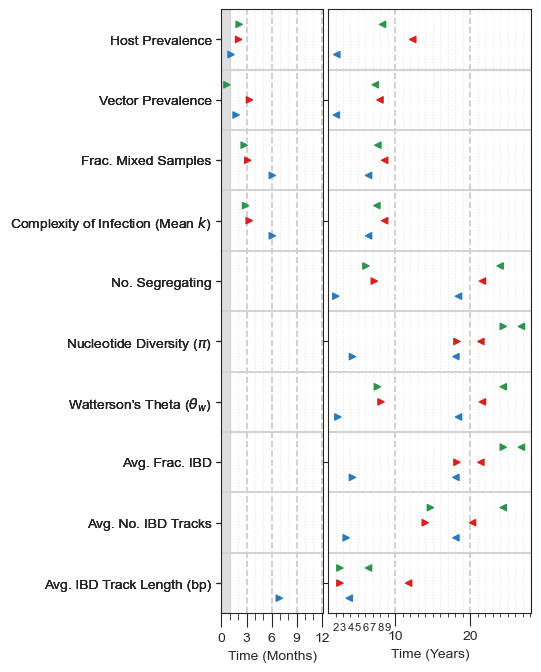

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(4, 8))

# Prepare slicing of axes
divider = make_axes_locatable(ax)
lax = divider.append_axes("left", size="50%", pad=0.05)


# Left plot
# --------------------------------------------------------------------------------
lax.scatter(x=df["tdelay_detect"],
            y=df["ix_adj"],
            s=psize,
            color=df["color"],
            marker=">")
lax.scatter(x=df["tdelay_equil"],
            y=df["ix_adj"],
            s=psize,
            color=df["color"],
            marker="<")
# Domain
lax.set_xlim(0, cut_axis_days)
lax.set_ylim((-0.5, len(plot_metrics) - 0.5))
# Lines
for m in ms: lax.axhline(m, color="lightgrey")
# Ticks
lax.set_yticks(df["ix"])
lax.set_yticklabels([genetic_names[m] for m in df["metric"]])
lax.xaxis.set_major_locator(plt.MultipleLocator(90))
lax.xaxis.set_minor_locator(plt.MultipleLocator(30))
lax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, tick: int(val/30.)))
lax.tick_params(axis='x', which='major', direction='out', length=10)
lax.tick_params(axis='x', which='minor', direction='out', length=5, labelsize=8, gridOn=True)
# Grid
lax.grid(axis='x', which='major', linestyle='dashed', linewidth=1.25)
lax.grid(axis='x', which='minor', linestyle='dotted', linewidth=0.8, alpha=0.5)
# Labels
lax.set_xlabel("Time (Months)")
# Patch delineating Intervention Window
lax.add_patch(patches.Rectangle(xy=(0, lax.get_ylim()[0]), 
                                width=30, 
                                height=lax.get_ylim()[1]-lax.get_ylim()[0], 
                                color='lightgrey', alpha=0.75, zorder=0)) 



# Right plot
# --------------------------------------------------------------------------------
ax.scatter(x=df["tdelay_detect"],
           y=df["ix_adj"],
           color=df["color"],
           s=psize,
           marker=">")
ax.scatter(x=df["tdelay_equil"],
           y=df["ix_adj"],
           color=df["color"],
           s=psize,
           marker="<")
# Domain
ax.set_xlim(cut_axis_days, ax.get_xlim()[1])
ax.set_ylim((-0.5, len(plot_metrics) - 0.5))
# Lines
for m in ms: ax.axhline(m, color="lightgrey")
# Labels
ax.set_yticklabels("")
# Ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(360*10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(360))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, tick: int(val/360.)))
ax.xaxis.set_minor_formatter(plt.FuncFormatter(lambda val, tick: int(val/360.) if 0 <= tick < 9 else ""))
ax.tick_params(axis='x', which='major', direction='out', length=9)
ax.tick_params(axis='x', which='minor', direction='out', length=3, labelsize=8, gridOn=True)
# Grid
ax.grid(axis='x', which='major', linestyle='dashed', linewidth=1.25)
ax.grid(axis='x', which='minor', linestyle='dotted', linewidth=0.8, alpha=0.5)
# Labels
ax.set_xlabel("Time (Years)")

I guess this looks like progress to me. The plot is definitely quite busy however.

## Other visualizations

In [38]:
epoch_df = pd.read_csv("../analysis/2020-04-30_bed-intv/epoch_df.csv")
ogs = np.load("../analysis/2020-04-30_bed-intv/ogs_array.npy")
t0 = np.load("../analysis/2020-04-30_bed-intv/sfs_t0.npy")

In [40]:
t0.shape

(5468,)

In [21]:
ogs.shape

(5468, 21, 85)

In [43]:
epoch_df.index = epoch_df.name

In [55]:
pre = (epoch_df.loc["InitVar", "t0"] <= t0) & (t0 <= epoch_df.loc["InitVar", "t1"])
post = (epoch_df.loc["CrashVar", "t0"] <= t0) & (t0 <= epoch_df.loc["CrashVar", "t1"])

In [57]:
focus_expt = 0
ogs_pre = ogs[pre, :, focus_expt]
ogs_post = ogs[post, :, focus_expt]

In [32]:
metric = "mean_k"
ix = [i for i, m in enumerate(genetic_metrics) if m == metric][0]
ix

8

In [72]:
ogs_pre = pd.DataFrame(ogs_pre, columns=genetic_metrics + ibd_metrics)
ogs_pre["Time"] = "Pre"
ogs_post = pd.DataFrame(ogs_post, columns=genetic_metrics + ibd_metrics)
ogs_post["Time"] = "Post"

In [73]:
ogs_df = pd.concat([ogs_pre, ogs_post], 0)

In [74]:
ogs_df.shape

(292, 22)

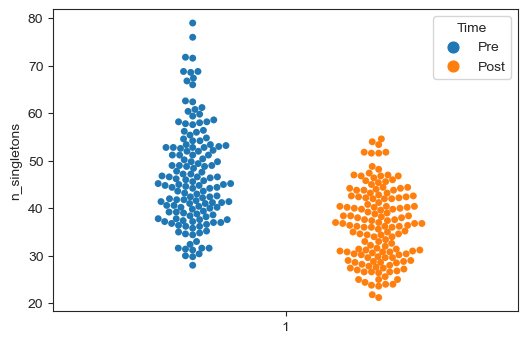

In [87]:
fig, ax = plt.subplots(1, 1)

sns.swarmplot(x=[1]*292,
              y=ogs_df["n_singletons"],
              split=True,
              hue=ogs_df["Time"])

In [89]:
len(tight_metrics)

10

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=())

In [68]:
ogs_pre

,n_re_genomes,n_mixed_genomes,frac_mixed_genomes,n_re_samples,n_mixed_samples,frac_mixed_samples,n_fixed_ref,n_fixed_alt,mean_k,n_barcodes,...,n_variants,n_segregating,n_singletons,pi,theta,tajd,avg_frac_ibd,avg_n_ibd,avg_l_ibd,Time
0,25.25,10.0,0.394872,20.0,4.75,0.2375,239.25,264.75,1.2625,24.75,...,760.75,496.0,35.0,0.164695,0.131036,1.032281,0.835305,130.103554,19.687686,Pre
1,26.00,11.6,0.439238,20.0,5.60,0.2800,244.40,263.60,1.3000,25.40,...,755.60,492.0,34.8,0.163938,0.129039,1.080323,0.836062,128.713625,23.028425,Pre
2,24.80,9.6,0.380067,20.0,4.80,0.2400,240.80,261.60,1.2400,24.80,...,759.20,497.6,41.8,0.164768,0.132127,0.995920,0.835232,129.894728,18.380242,Pre
3,25.60,11.0,0.428604,20.0,5.40,0.2700,243.20,270.20,1.2800,25.20,...,756.80,486.6,37.4,0.162085,0.128053,1.066151,0.837915,127.415476,21.181463,Pre
4,26.00,11.2,0.426345,20.0,5.20,0.2600,242.80,273.00,1.3000,25.40,...,757.20,484.2,31.6,0.161887,0.126936,1.099709,0.838113,127.190362,22.763896,Pre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,27.00,12.8,0.462805,20.0,5.80,0.2900,253.40,271.60,1.3500,25.80,...,746.60,475.0,53.4,0.158655,0.123370,1.139846,0.841345,126.039118,30.058179,Pre
142,27.60,14.2,0.508205,20.0,6.60,0.3300,241.80,263.40,1.3800,26.20,...,758.20,494.8,39.2,0.164725,0.127750,1.144523,0.835275,131.279356,26.288759,Pre
143,25.00,9.8,0.390256,20.0,4.80,0.2400,253.60,277.20,1.2500,24.20,...,746.40,469.2,46.0,0.154921,0.124291,0.990207,0.845079,123.508016,28.935901,Pre
144,25.80,11.6,0.434787,20.0,5.80,0.2900,248.80,268.00,1.2900,24.60,...,751.20,483.2,52.0,0.158509,0.127086,0.996400,0.841491,125.922275,32.192224,Pre


## Another

In [239]:
ops_mean = pd.read_csv("../analysis/2020-04-30_art-intv/ops_mean.csv")
ogs_mean = pd.read_csv("../analysis/2020-04-30_art-intv/ogs_mean.csv")

In [241]:
df = pd.merge(left=ops_mean, right=ogs_mean, on="t0")

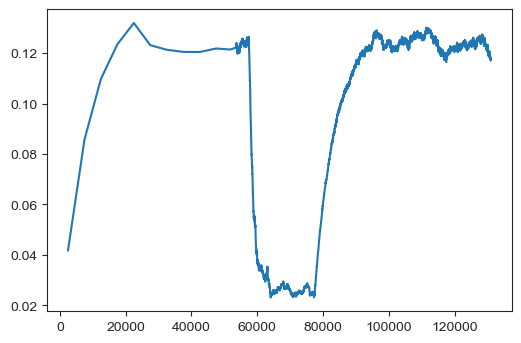

In [244]:
plt.plot(df["t0"], df["pi"])

In [247]:
df = df.query("t0 > 40000 and t0 < 70000")

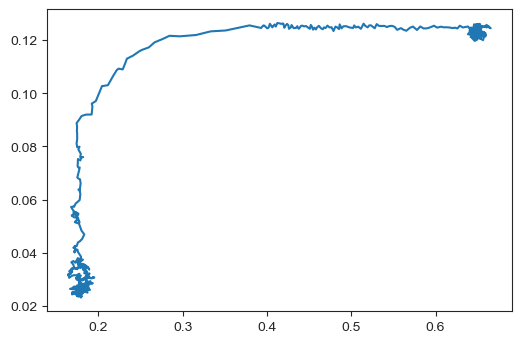

In [248]:
plt.plot(df["HX"], df["pi"])

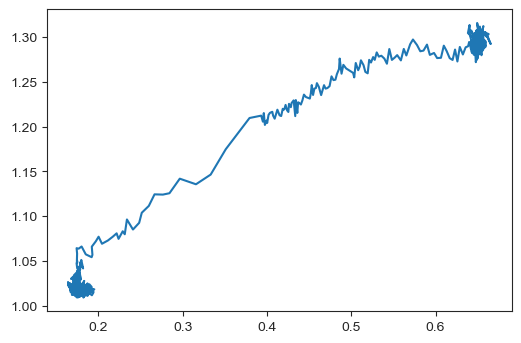

In [249]:
plt.plot(df["HX"], df["mean_k"])

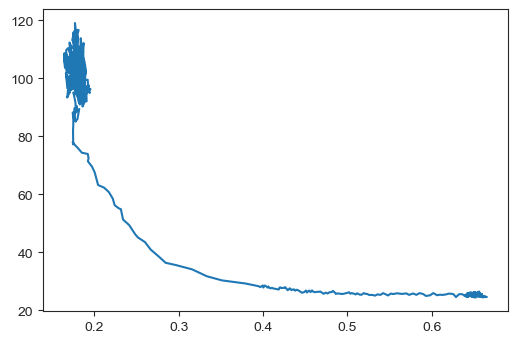

In [251]:
plt.plot(df["HX"], df["avg_l_ibd"])

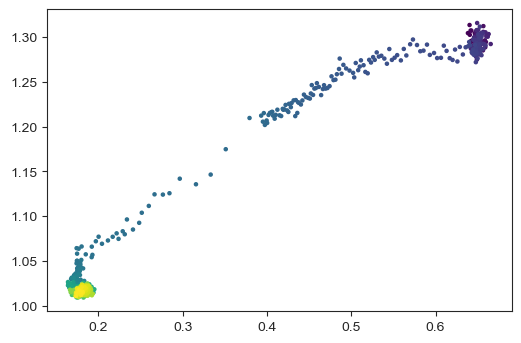

In [264]:
plt.scatter(df["HX"], 
            df["mean_k"],
            c=sns.color_palette("viridis", len(df)),
            s=5,
            marker='o')

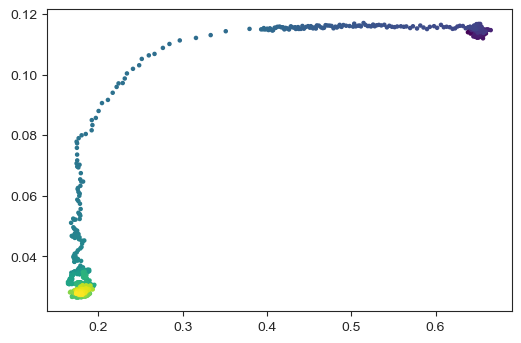

In [263]:
plt.scatter(df["HX"], 
            df["theta"],
            c=sns.color_palette("viridis", len(df)),
            s=5,
            marker='o')